In [1]:
# Base module
import dolfinx as _dolfinx
from dolfinx import mesh as _mesh
from dolfinx import fem as _fem
from dolfinx import nls as _nls
import ufl as _ufl
import numpy as _np
from matplotlib import pyplot as _plt

import typing as _typing
import shutil as _shutil
import re as _re

from ufl import FacetNormal, SpatialCoordinate, Measure
from ufl import TrialFunction, TestFunction, TrialFunctions, TestFunctions
from ufl import conditional
from dolfinx.fem import FunctionSpace


# Operators
class _Infix:
    """Create infix function from default"""

    def __init__(self, function):
        self.function = function

    def __ror__(self, other):
        return _Infix(lambda x, self=self, other=other: self.function(other, x))

    def __or__(self, other):
        return self.function(other)

    def __call__(self, value1, value2):
        return self.function(value1, value2)


dot = _Infix(_ufl.dot)
inner = _Infix(_ufl.inner)

npor = _Infix(_np.logical_or)
npand = _Infix(_np.logical_and)


def vector(*args):
    return _ufl.as_vector(tuple(args))


def I(func_like):
    """Create matrix Identity dimension of func_like

    Args:
        func_like (Function): Give geometric dimension

    Returns:
        Tensor: Identity
    """
    return _ufl.Identity(func_like.geometric_dimension())


# Functions:
def get_space_dim(space):
    """Get dimensions of X on space

    Args:
        space (fem.FunctionSpace): Space

    Returns:
        List: space dim, len
    """
    return (space.mesh.geometry.dim, len(space.dofmap.list.array))


def create_FacetTags_boundary(domain, bound_markers):
    """Mark boundary facets under conditious

    Args:
        domain (Domain): Domain
        bound_markers (mark,python_function): List of mark and function

    Return:
        tags(mesh.meshtags): Marked facets
    """
    facet_indices, facet_markers = [], []
    for (marker, condition) in bound_markers:
        facets = _mesh.locate_entities_boundary(
            domain,
            domain.topology.dim - 1,
            condition,
        )
        facet_indices.append(facets)
        facet_markers.append(_np.full_like(facets, marker))
    facet_indices = _np.hstack(facet_indices).astype(_np.int32)
    facet_markers = _np.hstack(facet_markers).astype(_np.int32)
    sorted_facets = _np.argsort(facet_indices)
    facet_tags = _mesh.meshtags(
        domain,
        domain.topology.dim - 1,
        facet_indices[sorted_facets],
        facet_markers[sorted_facets],
    )

    return facet_tags


def set_connectivity(domain):
    """Need to compute facets to Boundary value

    Args:
        domain (Mesh): Domain
    """
    domain.topology.create_connectivity(
        domain.topology.dim - 1,
        domain.topology.dim,
    )


# Classes
class DirichletBC:
    """
    Create Dirichlet condition.

    Args:
        space (fem.FunctionSpace): Function space.
        For several spaces:: first space is general.
        form (any function): Function
        combined_marker (Any): One from next::
        \nFunction - boundary marker function find geometrical
        \nAll - all boundary find entities
        \n(mesh.meshtags, marker) -Find entities marker of boundary from mesh tags

    Returns:
        condition (dirichletbc): Dirichlet condition
    """

    def __new__(cls, space, form, combined_marker):

        def set_dirichlet(dofs, form, space):
            if hasattr(form, 'function_space'):
                if form.function_space == space:
                    bc = _fem.dirichletbc(dofs=dofs, value=form)
                else:
                    bc = _fem.dirichletbc(V=space, dofs=dofs, value=form)
            else:
                bc = _fem.dirichletbc(V=space, dofs=dofs, value=form)
            return bc

        # FIXME: Maybe listable?
        if isinstance(space, tuple or list): space0 = space[0]
        else: space0 = space
        domain = space0.mesh

        if combined_marker == 'All':
            facets = _mesh.exterior_facet_indices(domain.topology)
            dofs = _fem.locate_dofs_topological(
                space,
                domain.topology.dim - 1,
                facets,
            )

        elif isinstance(combined_marker, tuple or list):
            marked_facets, marker = combined_marker
            facets = marked_facets.find(marker)
            dofs = _fem.locate_dofs_topological(
                space,
                domain.topology.dim - 1,
                facets,
            )

        else:
            dofs = _fem.locate_dofs_geometrical(space, combined_marker)

        bc = set_dirichlet(dofs, form, space0)

        return bc


class Function:
    """Function on new space. Default = 0

    Args:
        space (FunctionSpace): Function space
        form (): Any form: fem.Function,fem.Constant,fem.Expression,
        ufl_function, callable function, number

    Returns:
        fem.Function: Function
    """

    def __new__(cls, space, form=None, name=None):

        # FIXME: x-x not beauty
        def from_constant():
            if len(form.ufl_shape) == 0:
                form2 = form.value + (cords[0] - cords[0])
            else:
                form2 = vector(*form.value)
                form2 += vector(*map(lambda x, y: x - y, cords, cords))
            expression = _fem.Expression(
                form2,
                space.element.interpolation_points(),
            )
            return expression

        def from_ufl():
            if len(form.ufl_shape) == 0:
                form2 = form + (cords[0] - cords[0])
            else:
                form2 = form + vector(*map(lambda x, y: x - y, cords, cords))
            expression = _fem.Expression(
                form2,
                space.element.interpolation_points(),
            )
            return expression

        def from_number():
            if not hasattr(form, '__getitem__'):
                form2 = form + (cords[0] - cords[0])
            else:
                form2 = vector(*form)
                form2 += vector(*map(lambda x, y: x - y, cords, cords))
            expression = _fem.Expression(
                form2, space.element.interpolation_points()
            )
            return expression

        func = _fem.Function(space)
        if name is not None: func.name = name
        if form is None: return func

        form_type = str(form.__class__)[8:-2]
        cords = _ufl.SpatialCoordinate(space)
        if form_type == ('dolfinx.fem.function.Function'):
            expression = form
        elif form_type == ('dolfinx.fem.function.Constant'):
            expression = from_constant()
        elif form_type[:3] == 'ufl':
            expression = from_ufl()
        elif form_type == 'function':
            expression = form
        elif form_type == ('dolfinx.fem.function.Expression'):
            expression = form
        elif not callable(form):
            expression = from_number()
        else:
            raise ValueError(f'Uncorrect form:{form_type}')

        func.interpolate(expression)
        return func


class Constant:

    def __new__(cls, domain_space, const):
        """Constant on space

        Args:
            space (fem.FunctionSpace| domain): Space or domain
            const (auny number): Any number

        Returns:
            fem.function.Constant: Constant on space
        """
        return _fem.Constant(domain_space, _fem.petsc.PETSc.ScalarType(const))


# Solvers
class LinearProblem:
    """Create linear  problem

        Args:
            a (ufl.Form): bilinear form
            L (ufl.Form): linear form
            bcs (Dirichlet): Dirichlet conditious.
            u (fem.Function): Function to be solved.
            \npetsc_options (dict): Options to petsc.
            Defaults to { 'ksp_type': 'preonly', 'pc_type': 'lu' }.
            \nassemble_options (dict): Options to assemble bilinear and linear forms.
            Defaults to {'assebmle_A': True, 'assemble_B': True}.
            \nghost_opions (dict): GhostUpdate potions.
            Defaults to  {'addv': ADD,'mode': REVERSE}.
            \nform_compiler_params (dict): Form compiler options.
            Defaults to {}.
            \njit_params (dict): JIT parmetrs.
            Defaults to {}.
        """

    def __init__(
        self,
        a: _ufl.Form,
        L: _ufl.Form,
        bcs: list,
        u: _fem.Function,
        petsc_options={
            'ksp_type': 'preonly', 'pc_type': 'lu'
        },
        assemble_options={
            'assemble_A': True, 'assemble_b': True
        },
        ghost_opions={},
        form_compiler_params={},
        jit_params={},
    ):
        # FIXME: Maybe need setiings options to forms or not?
        def set_options(self, petsc_options):
            ksp = self._solver
            problem_prefix = f'dolfinx_solve_{id(self)}'
            ksp.setOptionsPrefix(problem_prefix)
            opts = _fem.petsc.PETSc.Options()
            opts.prefixPush(problem_prefix)
            for k, v in petsc_options.items():
                opts[k] = v
            opts.prefixPop()
            ksp.setFromOptions()
            # self._A.setOptionsPrefix(problem_prefix)
            # self._A.setFromOptions()
            # self._b.setOptionsPrefix(problem_prefix)
            # self._b.setFromOptions()
            pass

        self._u = u
        self.bcs = bcs

        # A form
        self._a = _fem.form(
            a,
            form_compiler_params=form_compiler_params,
            jit_params=jit_params,
        )
        self._A = _fem.petsc.create_matrix(self._a)

        # b form
        self._L = _fem.form(
            L,
            form_compiler_params=form_compiler_params,
            jit_params=jit_params,
        )
        self._b = _fem.petsc.create_vector(self._L)

        # Creating solver
        self._solver = _fem.petsc.PETSc.KSP().create(
            self._u.function_space.mesh.comm
        )
        self._solver.setOperators(self._A)
        set_options(self, petsc_options)

        # Another options
        self._ghost_opions = {
            'addv': _fem.petsc.PETSc.InsertMode.ADD,
            'mode': _fem.petsc.PETSc.ScatterMode.REVERSE,
        }
        self._ghost_opions.update(ghost_opions)

        # Assembling
        self.assemble_options = assemble_options
        if self.assemble_options['assemble_A']: self._assemble_A()
        if self.assemble_options['assemble_b']: self._assemble_b()

    def _assemble_A(self):
        """Assemle bilinear form"""
        self._A.zeroEntries()
        _fem.petsc._assemble_matrix_mat(self._A, self._a, bcs=self.bcs)
        self._A.assemble()

    def _assemble_b(self):
        """Assemble linear form"""
        with self._b.localForm() as b_loc:
            b_loc.set(0)
        _fem.petsc.assemble_vector(self._b, self._L)
        _fem.petsc.apply_lifting(self._b, [self._a], bcs=[self.bcs])
        self._b.ghostUpdate(
            addv=self._ghost_opions['addv'],
            mode=self._ghost_opions['mode'],
        )
        _fem.petsc.set_bc(self._b, self.bcs)

    def solve(self):
        """Solve function

        Returns:
            fem.Function: Solved function
        """
        if not self.assemble_options['assemble_A']: self._assemble_A()
        if not self.assemble_options['assemble_b']: self._assemble_b()

        result = self._solver.solve(self._b, self._u.vector)
        self._u.x.scatter_forward()
        return result

    @staticmethod
    def KSP_types():
        """Get KSP types"""
        return _fem.petsc.PETSc.KSP.Type

    @staticmethod
    def PC_types():
        """Get PC types"""
        return _fem.petsc.PETSc.PC.Type

    @staticmethod
    def ghost_updates():
        """Get ghost_update types"""
        return (_fem.petsc.PETSc.InsertMode, _fem.petsc.PETSc.ScatterMode)

    @property
    def L(self) -> _fem.FormMetaClass:
        """The compiled linear form"""
        return self._L

    @property
    def a(self) -> _fem.FormMetaClass:
        """The compiled bilinear form"""
        return self._a

    @property
    def A(self) -> _fem.petsc.PETSc.Mat:
        """Matrix operator"""
        return self._A

    @property
    def b(self) -> _fem.petsc.PETSc.Vec:
        """Right-hand side vector"""
        return self._b

    @property
    def solver(self) -> _fem.petsc.PETSc.KSP:
        """Linear solver object"""
        return self._solver


class NonlinearProblem:
    """Create nonlinear problem

        Args:
            F (ufl.Form): Nonlinear equation form
            bcs (Dirichlet): Dirichlet conditious.
            u (fem.Function): Function to be solved.
            \nJ (ufl.Form): Jacobian matrix. Defaults None.
            \npetsc_options (dict): Options to petsc. Defaults to {
            'ksp_type': 'preonly',
            'pc_type': 'lu',
            'pc_factor_mat_solver_type': 'mumps',
            }.
            \nsolve_options (dict): Options to NEwton solwer.
            Defaults to {'convergence': 'incremental', 'tolerance': 1E-6}.
            \nghost_opions (dict):  You cant change it
            {'addv': INSERT,'mode': FORWARD}
            \nform_compiler_params (dict): Form compiler options.
            Defaults to {}.
            \njit_params (dict): JIT parmetrs.
            Defaults to {}.
        """

    # TODO: Make succession
    def __init__(
        self,
        F: _ufl.Form,
        bcs: list,
        u: _fem.Function,
        J: _ufl.Form = None,
        solve_options={
            'convergence': 'incremental', 'tolerance': 1E-6
        },
        petsc_options={
            'ksp_type': 'preonly',
            'pc_type': 'lu',
            'pc_factor_mat_solver_type': 'mumps',
        },
        form_compiler_params={},
        jit_params={},
    ):

        def set_options(self, petsc_options, solve_options):
            self._solver.convergence_criterion = solve_options['convergence']
            self._solver.rtol = solve_options['tolerance']

            ksp = self._solver.krylov_solver
            problem_prefix = ksp.getOptionsPrefix()
            opts = _fem.petsc.PETSc.Options()
            opts.prefixPush(problem_prefix)
            for k, v in petsc_options.items():
                opts[k] = v
            ksp.setFromOptions()

        self._u = u
        self.bcs = bcs

        pr = _fem.petsc.NonlinearProblem(
            F=F,
            u=self._u,
            bcs=self.bcs,
            J=J,
            form_compiler_params=form_compiler_params,
            jit_params=jit_params,
        )
        self._a = pr.a
        self._L = pr.L

        # Creating solver
        self._solver = _nls.petsc.NewtonSolver(
            self._u.function_space.mesh.comm,
            pr,
        )
        set_options(
            self, petsc_options=petsc_options, solve_options=solve_options
        )

    def solve(self):
        """Solve function

        Returns:
            fem.Function: Solved function
        """
        result = self._solver.solve(self._u)
        return result

    @staticmethod
    def KSP_types():
        """Get KSP types"""
        return _fem.petsc.PETSc.KSP.Type

    @staticmethod
    def PC_types():
        """Get PC types"""
        return _fem.petsc.PETSc.PC.Type

    @property
    def solver(self) -> _fem.petsc.PETSc.KSP:
        """Linear solver object"""
        return self._solver

    @property
    def L(self) -> _fem.FormMetaClass:
        """The compiled linear form"""
        return self._L

    @property
    def a(self) -> _fem.FormMetaClass:
        """The compiled bilinear form"""
        return self._a


# Post process
def clear_savedir(path_save):
    """Clear directory in VTK folder"""
    try:
        _shutil.rmtree(path_save)
        print(f'Directory: <{path_save}> cleared')
    except:
        print(f'Directory: <{path_save}> empty yet')



def show_plots(
    functions: _typing.List[Function],
    fig=None,
    ax=None,
    show_points=False,
):
    """Create plot from fem.Function
    
    Args:
        fig (plt.Figure): Figure
        lists (fem.Function, str): List of (u, title)
        points_on (bool): If true create scatter
    """
    if (fig or ax) is None:
        fig, ax = _plt.subplots()
        fig.set_size_inches(16, 8)
    for func in functions:
        x = func.function_space.tabulate_dof_coordinates()[:, 0]
        y = func.x.array
        cord = _np.array([x, y])
        cord = cord[:, _np.argsort(cord[0])]
        ax.plot(cord[0], cord[1], label=func.name, linewidth=1)
        if show_points: ax.scatter(func.x, func.y, s=0.5)
    ax.legend(
        bbox_to_anchor=(1.01, 0.5),
        borderaxespad=0,
        loc='center left',
    )


class PostProcess2D:
    """Class for different methods to plot functions"""

    @staticmethod
    def data_construct(dofs, x_array):
        """Constuct X data

        Args:
            dofs (fem.dofs): Dofs
            x_array (fem.array): X array

        Returns:
            np.array: Data
        """
        data = _np.column_stack((dofs[:, 0:2], x_array))
        x_data = data[:, 0]
        y_data = data[:, 1]
        z_data = data[:, 2]
        return [x_data, y_data, z_data]

    @staticmethod
    def line_collision(domain, line_cord):
        """Generate points and cells of colliding domain and line

        Args:
            domain (mesh): Domain
            line_cord (array): 3D line contervertor of coordinates

        Returns:
            Tuple: Collision points and collision cells
        """
        bb_tree = _dolfinx.geometry.BoundingBoxTree(domain, domain.topology.dim)
        cells_on_line = []
        points_on_line = []
        cell_candidates = _dolfinx.geometry.compute_collisions(
            bb_tree, line_cord.T
        )
        colliding_cells = _dolfinx.geometry.compute_colliding_cells(
            domain, cell_candidates, line_cord.T
        )
        for i, point in enumerate(line_cord.T):
            if len(colliding_cells.links(i)) > 0:
                points_on_line.append(point)
                cells_on_line.append(colliding_cells.links(i)[0])

        points_on_line = _np.array(points_on_line, dtype=_np.float64)
        return (points_on_line, cells_on_line)

    # FIXME: simplify
    @staticmethod
    def graph2D(fig, lists, natural_show=False, points_on=False):
        """Create graph from fem.Function

        Args:
            fig (plt.Figure): Figure
            lists (fem.Function , plt.Axes, str): List of (u, curent axes, title)
            natural_show (bool): True = tripcolor, False = tricontourf
            points_on (bool): True = set points
        """

        for lis in lists:
            u, ax, title = lis
            dofs = u.function_space.tabulate_dof_coordinates()
            ax.set_title(title)
            data = PostProcess1D.data_construct(dofs, u.x.array)

            if points_on:
                ax.plot(data[0], data[1], 'o', markersize=2, color='grey')

            if natural_show:
                plot = ax.tripcolor(*data)
            else:
                try:
                    levels = _np.linspace(u.x.array.min(), u.x.array.max(), 10)
                    plot = ax.tricontourf(*data, levels=levels)
                except:
                    print(f'{title} - error')

            ax.set_aspect(1)
            fig.colorbar(plot, ax=ax)
        return

    @staticmethod
    def L1_error(space, u0, u1):
        """L1 error

        Args:
            space (fem.Space): Space
            u0 (fem.Function): Default function
            u1 (fem.Function): Compare function

        Returns:
            fem.Function: L1 error
        """
        L1 = Function(space, abs(u1 - u0))
        return L1


In [2]:
class Parametric:

    def __init__(self, parametrs: dict) -> None:
        # FIXME: how make more beatiful?

        for key, value in parametrs.items():
            if isinstance(value, dict) and value.get('dict_flag') is None:
                new_value = Parametric(value)
            elif isinstance(value, dict) and value.get('dict_flag') is True:
                new_value = value.copy()
                new_value.pop('dict_flag', None)
            else:
                new_value = value
            setattr(self, key, new_value)


In [3]:
import typing
# from local_fenics.base import *
import json
import shutil
import os
# Solving
import dolfinx
from dolfinx import mesh, fem, io, nls
from dolfinx.fem import VectorFunctionSpace
from mpi4py import MPI
import numpy as np

# Operators
import ufl
from ufl import variable
from ufl import diff as D
from ufl import nabla_div, nabla_grad, grad, div
from ufl import as_matrix as matrix
from ufl import lhs, rhs, split
from ufl import exp, sym, tr, sqrt, ln, sin, cos
# Graphics
import matplotlib.pyplot as plt
# Logging
from tqdm import tqdm


# Saving
def view_file1D(
    name,
    dir='/home/VTK/System1D_files/',
    view_dir='/home/VTK/System1D_files/0',
):
    shutil.copytree(dir + name, view_dir, dirs_exist_ok=True)


def custom_input(description, dir_save, rewrite=False):
    while True:
        save_name = None
        save_name = input(description + f' Previous: {save_name}')
        if save_name == '': raise KeyError('No file name')
        folder_exist = os.path.isdir(dir_save + save_name)
        if not folder_exist or rewrite: return save_name


class Save_par:

    def __init__(self, save_name='test') -> None:
        self.dir_save = '/home/Solver/Solves/'
        self.file_name = '/system1D'
        self.save_name = save_name


class Time_par:
    # FIXME: selector
    def __init__(self, T=999999, n_steps=999999, dt=999999, n_shecks=10):
        if dt == 999999:
            dt = T / n_steps
        elif n_steps == 999999:
            n_steps = int(T / dt)
        elif T == 999999:
            T = n_steps * dt
        if T != dt * n_steps: raise ValueError('Incorrect time parametrs')
        self.T = T
        self.dt = dt
        self.n_steps = n_steps
        self.n_shecks = n_shecks


class Mesh_par:

    def __init__(self, left=0, right=1, domain_intervals=100, degree=1) -> None:
        self.left = left
        self.right = right
        self.domain_intervals = domain_intervals
        self.family = 'CG'
        self.degree = degree


class Const_par:

    def __init__(
        self,
        light_left=0.4,
        light_right=0.6,
        gen_rate=0.01,
        P_step=0.13,
        a_rate=0.1,     # NM
        b_rate=1,     # PM
        e_rate=1     # NP
    ) -> None:
        self.gamma = 4
        self.P_step = P_step
        self.gen_rate = gen_rate
        self.a_rate = a_rate
        self.b_rate = b_rate
        self.e_rate = e_rate
        self.light = {'left': light_left, 'right': light_right}


class Initial_par:

    def __init__(self, N0=0.2, P0=0.001) -> None:
        self.N0 = N0
        self.P0 = P0


class Solve_confs_par:

    def __init__(
        self,
        petsc_options={
            'ksp_type': 'preonly',
            'pc_type': 'lu',
            'pc_factor_mat_solver_type': 'mumps'
        },
        solve_options={
            'convergence': 'incremental', 'tolerance': 1E-6
        },
        form_compiler_params={},
        jit_params={}
    ) -> None:
        self.petsc_options = petsc_options
        self.solve_options = solve_options
        self.form_compiler_params = form_compiler_params
        self.jit_params = jit_params


class DATA_class:

    def __init__(
        self,
        save=Save_par(),
        time=Time_par(),
        mesh=Mesh_par(),
        const=Const_par(),
        initial=Initial_par(),
        solve_confs=Solve_confs_par(),
    ):
        self.save = save
        self.time = time
        self.mesh = mesh
        self.const = const
        self.initial = initial
        self.solve_confs = solve_confs


In [4]:
const = Const_par(
    light_left=0.1,
    light_right=0.3,
    gen_rate=0.01,
    a_rate=1,
    b_rate=0.1,
    e_rate=0.5,
    P_step=0.13
)
qual = Time_par(dt=0.001,T=2)
res = Mesh_par(domain_intervals=1000, degree=2)
sol = Solve_confs_par(
    solve_options={
        'convergence': 'incremental', 'tolerance': 1E-20
    }
)
DATA = DATA_class(
    time=qual,
    const=const,
    mesh=res,
    # solve_confs=sol,
)

In [5]:
# Task
def solve(
    n_steps=DATA.time.n_steps,
    reset=True,
    save=False,
    save_f={
        'sqn': False, 'sqp': False
    }
):

    def set_next():
        # TODO: interpolate bcs
        S0.interpolate(S)
        TIME.value += DATA.time.dt

    def save_functions(file, time):
        file.write_function(NS, time)
        file.write_function(PS, time)
        light = Function(W0, LIHGT,'Light')

        if save_f['sqn']:
            flux_N = Function(W0, SQN,'flux_N')
            file.write_function(flux_N, time)
        if save_f['sqp']:
            flux_P = Function(W1, SQP,'flux_P')
            file.write_function(flux_P, time)

    def solve_default(steps):
        for step in steps:
            set_next()
            steps.set_description(f'Solving PDE. Time:{TIME.value:.2f}')
            PROBLEM.solve()

    def solve_with_save(steps, data_save: Save_par = DATA.save):
        clear_savedir(data_save.dir_save + data_save.save_name)
        save_path = data_save.dir_save + data_save.save_name + data_save.file_name
        check_every = int(DATA.time.n_steps / DATA.time.n_shecks)

        NS.name = 'neutral'
        PS.name = 'polimer'
        with io.XDMFFile(DOMAIN.comm, save_path + '.xdmf', 'w') as file:
            file.write_mesh(DOMAIN)
            for step in steps:
                if step % check_every == 0:
                    steps.set_description(f'Solving PDE. Time:{TIME.value:.2f}')
                    save_functions(file, save_f, TIME.value)
                set_next()
                PROBLEM.solve()
            save_functions(file, save_f, TIME.value)

    if reset: set_initial()
    steps_line = tqdm(
        desc=f'Solving PDE. Time:{TIME.value:.3f}',
        iterable=np.arange(0, n_steps, dtype=int),
    )
    if save: solve_with_save(steps_line, data_save=DATA.save)
    else: solve_default(steps_line)


class Light_types:

    def __init__(self, left=0.4, right=0.6, **parametrs):
        if left >= right: raise ValueError('left value >= right value')
        self.left = left
        self.right = right
        self.parametrs = parametrs

    def sharp(self):
        func = conditional(X <= self.right, 1, 0)
        func *= conditional(X >= self.left, 1, 0)
        return func


def create_dirichlet():
    # FIXME: multielement space
    # decorator for automatic interpolation
    BCS1 = Function(W0, 2 * X)
    bcs = [
        DirichletBC(
            space=BCS1.function_space,
            combined_marker=lambda x: np.isclose(x[0], 0),
            form=BCS1,
        )
    ]
    return []


def set_initial(data: Initial_par = DATA.initial):
    # TODO: reset bcs
    NS.interpolate(Function(W0, data.N0))
    PS.interpolate(Function(W1, data.P0))
    S.x.scatter_forward()
    S0.interpolate(S)

    TIME.value = 0
    global PROBLEM
    confs = DATA.solve_confs
    PROBLEM = NonlinearProblem(
        F=EQUATION_N + EQUATION_P,
        bcs=BCS,
        u=S,
        solve_options=confs.solve_options,
        petsc_options=confs.petsc_options,
        form_compiler_params=confs.form_compiler_params,
        jit_params=confs.jit_params,
    )


def draw(
    show_f={'sqn': False, 'sqp': False},
    flux_scale=100,
    show_points=False,
):     #yapf: disable

    light_col = Function(W0, LIHGT, 'Light')
    N_col = Function(W0, NS, 'neutral')
    P_col = Function(W0, PS, 'polimer')
    M_col = Function(W0, 1 - NS - PS, 'monomer')
    SQN_col = Function(W0, flux_scale * SQN, 'flux N')
    SQP_col = Function(W0, flux_scale * SQP, 'flux P')

    fig, ax = plt.subplots()
    fig.set_size_inches(20, 10)

    collection = [N_col, light_col, M_col, P_col]
    if show_f['sqn']: collection.append(SQN_col)
    if show_f['sqp']: collection.append(SQP_col)
    show_plots(
        fig=fig,
        ax=ax,
        functions=collection,
        show_points=show_points,
    )


def str_repr(func, pars: list = {}):
    # TODO: for constants
    rep = str(func)
    rep = _re.sub(r'\{ A \| A_\{i_(\d|\{\d+\})\} \=', '', rep)
    rep = _re.sub(r'\[i_(\d|{\d+})]', '', rep)
    rep = _re.sub(r'dx.+[)]', 'dx', rep)
    rep = _re.sub(r'ds.+[)]', 'ds', rep)
    for key, value in pars.items():
        rep = rep.replace(key, value)

    base = {
        'v_0[0]': 'v',
        'v_0[1]': 'u',
        '-1 * ': '-',
        '+ -': '-',
        'f[0]': 'N',
        'f[1]': 'P',
        '{': '{\n',
        '} *': '\n} *',
    }
    for key, value in base.items():
        rep = rep.replace(key, value)

    beauty = {
        '(grad(P))': 'grad(P)',
        '(grad(N))': 'grad(N)',
        '(grad(u))': 'grad(u)',
        '(grad(v))': 'grad(v)',
        '})': ')',
        '+ (': '\n + (',
    }
    for key, value in beauty.items():
        rep = rep.replace(key, value)

    for key, value in pars.items():
        rep = rep.replace(key, value)
    return rep


def _element():
    el = ufl.FiniteElement(
        family=DATA.mesh.family,
        cell=DOMAIN.ufl_cell(),
        degree=DATA.mesh.degree,
    )
    return el * el


def create_constants(data: Const_par = DATA.const):
    # TODO: const selector
    gen_rate = data.gen_rate
    stepwise_cP = data.P_step
    a_NM = gen_rate * data.a_rate
    b_PM = gen_rate * data.b_rate * exp(-P / stepwise_cP)
    e_NP = gen_rate * data.e_rate * exp(-P / stepwise_cP)

    gamma = data.gamma
    m = 1 - P - N
    under_ln = m / (1-N)
    power = (gamma-1) / gamma
    reaction = gamma * m * (-ln(under_ln))**power
    return a_NM, b_PM, e_NP, reaction


def create_surFluxes():

    def robin_bound(f, const, external, **args):
        return -const * (external-f)

    def neumann(f, value, **args):
        return -value

    def like_eq(f, N_external, P_external, **args):
        h = (DATA.mesh.right - DATA.mesh.left) / DATA.mesh.domain_intervals
        if f == N:
            flux_N = 0
            flux_N += -A_NM * (N_external-N)
            flux_N += +A_NM * P * (N_external-N)
            flux_N += -E_NP * P * (N_external-N)
            flux_N += -A_NM * N * (P_external-P)
            flux_N += +E_NP * N * (P_external-P)
            return flux_N / h
        else:
            flux_P = 0
            flux_P += -B_PM * (P_external-P)
            flux_P += +B_PM * N * (P_external-P)
            flux_P += -E_NP * N * (P_external-P)
            flux_P += -B_PM * P * (N_external-N)
            flux_P += +E_NP * P * (N_external-N)
            return flux_P / h

    middle = (DATA.mesh.right - DATA.mesh.left) / 2
    left = conditional(X <= middle, 1, 0)

    N_flux = like_eq(N, DATA.initial.N0, DATA.initial.P0)
    P_flux = like_eq(P, DATA.initial.N0, DATA.initial.P0)

    # coef = DATA.constants.a_rate* DATA.resolution.domain_intervals * DATA.constants.gen_rate
    # N_flux = robin_bound(N, coef, DATA.initial.N0)
    # P_flux = robin_bound(P, coef, DATA.initial.P0)
    # N_flux, P_flux
    return 0, 0


def create_equation():

    def create_facets():
        # TODO: boundary tags
        set_connectivity(DOMAIN)
        ds = Measure("ds", domain=DOMAIN)
        return ds

    def inside_flux():
        flux_N = 0
        flux_N += -A_NM * grad(N)
        flux_N += +A_NM * P * grad(N)
        flux_N += -E_NP * P * grad(N)
        flux_N += -A_NM * N * grad(P)
        flux_N += +E_NP * N * grad(P)

        flux_P = 0
        flux_P += -B_PM * grad(P)
        flux_P += +B_PM * N * grad(P)
        flux_P += -E_NP * N * grad(P)
        flux_P += -B_PM * P * grad(N)
        flux_P += +E_NP * P * grad(N)
        return flux_N, flux_P

    dx = Measure('cell', subdomain_id='everywhere')
    dt = DATA.time.dt
    ds = create_facets()
    u, v = TestFunctions(W)
    qN, qP = inside_flux()

    equationN = (1/dt) * (N-N0) * u * dx
    equationN += -(qN|inner|grad(u)) * dx
    equationN += u * SQN * ds

    equationP = (1/dt) * (P-P0) * v * dx
    equationP += -(qP|dot|grad(v)) * dx
    equationP += -LIHGT * REACTION * v * dx
    equationP += v * SQP * ds

    return equationN, equationP


# General
DOMAIN = mesh.create_interval(
    nx=DATA.mesh.domain_intervals,
    comm=MPI.COMM_WORLD,
    points=[DATA.mesh.left, DATA.mesh.right],
)
W = FunctionSpace(mesh=DOMAIN, element=_element())
W0, _ = W.sub(0).collapse()
W1, _ = W.sub(1).collapse()
X = SpatialCoordinate(W)[0]

# Functions
S, S0 = Function(W), Function(W)
N, P = split(S)
N0, P0 = split(S0)
NS = S.sub(0)
PS = S.sub(1)
TIME = Constant(W0, 0)
LIHGT = Light_types(**DATA.const.light).sharp()
# *conditional(TIME<=1.5,1,0)

# Equation
A_NM, B_PM, E_NP, REACTION = create_constants()
SQN, SQP = create_surFluxes()
BCS = create_dirichlet()
EQUATION_N, EQUATION_P = create_equation()
PROBLEM = []
set_initial()

# Dump
# raplace = {
#     str(A_NM): 'A_NM',
#     str(B_PM): 'B_PM',
#     str(E_NP): 'E_NP',
#     str(LIHGT): 'light',
#     str(REACTION): 'REACTION',
# }
# print(str_repr(EQUATION_N))

In [6]:
solve(
    reset=False,
    n_steps=1000,
)

Solving PDE. Time:1.00: 100%|██████████| 1000/1000 [00:34<00:00, 28.67it/s]


In [22]:
class ArrayFunc:

    def __init__(self, func: fem.Function, name=None):
        self.x = func.function_space.tabulate_dof_coordinates()[:, 0]
        self.y = func.x.array
        self.cord = _np.array([self.x, self.y])
        self.name = name

    def sort(self):
        self.cord = self.cord[:, _np.argsort(self.x)]
        self.x = self.cord[0]
        self.y = self.cord[1]

    def translate(self, x0):
        diapason  = abs(min(self.x) -max(self.y))
        x_new = (self.x -x0)
        self.x = x_new - diapason*(x_new//diapason)

    def mirror(self, x0=0):
        self.cord[0] = -(self.cord[0] - x0)
        self.sort()

    # def create_function(self, space):
    #     return Function(space, self.cord)

    def plot(self, xlim=None, ylim=None):
        fig, ax = _plt.subplots()
        fig.set_size_inches(20, 10)
        self.sort()
        ax.plot(self.x, self.y, label=self.name, linewidth=1)
        if xlim is not None: ax.set_xlim(xlim)
        if ylim is not None: ax.set_ylim(ylim)

In [9]:
(x0-15.3)

-14.600000000000001

In [10]:
lent*(float(res//lent))

-15.0

In [17]:
def test(x):
    global glob
    glob  = x
    
    return 0*x[0]
a= fem.Function(W0)
a.interpolate(test)
t1 = glob[0]
t2 = W0.tabulate_dof_coordinates()[:,0]

t1_set = set(t1) 
t2_set = set (t2)
print(len(t1),len(t1_set),len(t2_set))

3000 2001 2001


In [12]:
# func_l = np.zeros((2,len(W0.tabulate_dof_coordinates()[:,0])))
# func_l[0]=W0.tabulate_dof_coordinates()[:,0]
# x=func_l[0]

# func_l[1]=1
# y= func_l[1]
# y_test = fem.Function(W0)
# y_test.interpolate(func_l)

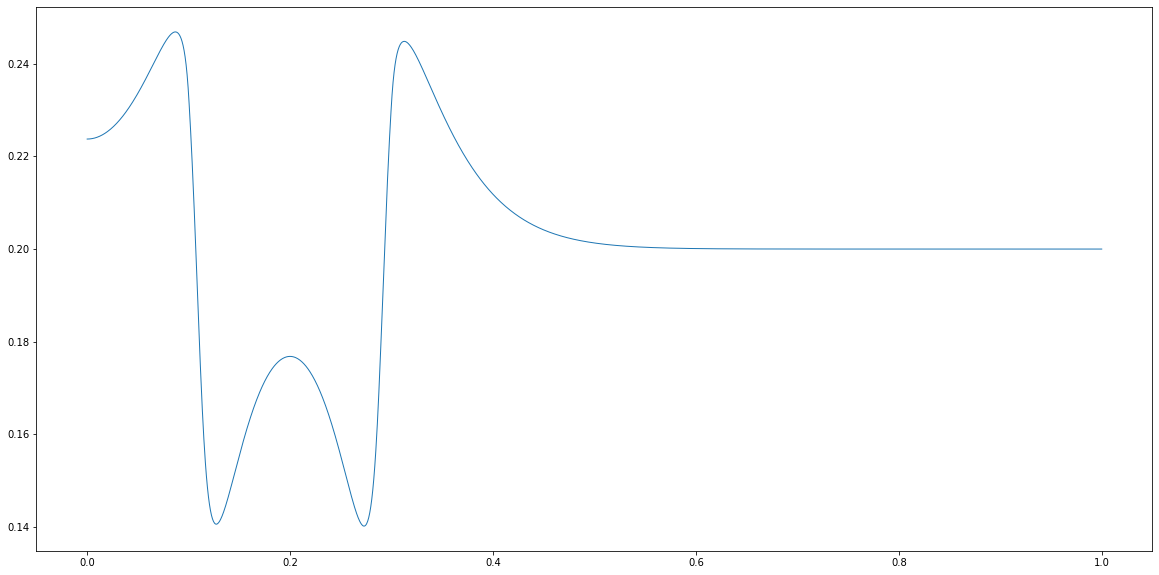

In [23]:
n_test = ArrayFunc(Function(W0,NS),'n')
n_test.plot()

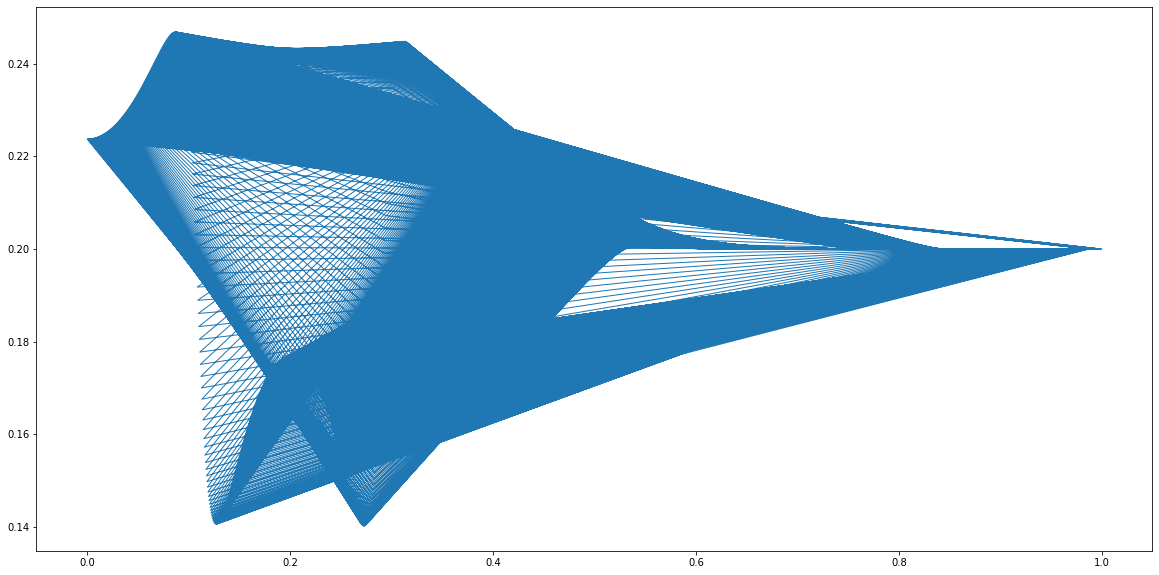

In [24]:
n_test.translate(0.2)
n_test.plot()

In [15]:
a=np.ufunc()
a(t2)

TypeError: cannot create 'numpy.ufunc' instances